# 1. Setup and Import Libraries

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from collections import deque
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 2. Download 25+ Years of Data for SPY, QQQ, DIA

In [74]:
tickers = ['SPY', 'QQQ', 'DIA', '^VIX']
start_date = "2000-01-01"
end_date = "2025-05-31"

data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Check data

In [75]:
for ticker in data:
    print(f"=== {ticker} - First 5 rows ===")
    display(data[ticker].head())
    
    print(f"=== {ticker} - Last 5 rows ===")
    display(data[ticker].tail())

=== SPY - First 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2000-01-03,92.414909,94.202048,91.422055,94.202048,8164300
2000-01-04,88.800934,91.541213,88.731434,91.203642,8089800
2000-01-05,88.959793,89.932791,87.212369,88.920079,12177900
2000-01-06,87.530045,89.912895,87.530045,88.721470,6227200
2000-01-07,92.613480,92.613480,88.999489,89.158346,8066500


=== SPY - Last 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2025-05-23,579.109985,581.809998,575.599976,575.979980,76029000
2025-05-27,591.150024,591.309998,578.429993,586.070007,72588500
2025-05-28,587.729980,592.770020,586.989990,591.559998,68445500
2025-05-29,590.049988,593.200012,586.070007,593.059998,69973300
2025-05-30,589.390015,591.130005,583.239990,588.929993,90601200


=== QQQ - First 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,QQQ,QQQ,QQQ,QQQ,QQQ
Date,,,,,
2000-01-03,80.314308,81.532797,76.923731,81.532797,36345200
2000-01-04,74.804581,79.254712,74.539692,77.983246,33786600
2000-01-05,72.897400,75.970110,71.414023,74.168866,42496600
2000-01-06,67.891006,74.592694,67.599629,73.639094,37134800
2000-01-07,76.287979,76.287979,69.930648,70.301492,28138200


=== QQQ - Last 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,QQQ,QQQ,QQQ,QQQ,QQQ
Date,,,,,
2025-05-23,509.239990,511.839996,505.579987,506.179993,58368100
2025-05-27,521.219971,521.710022,514.590027,516.150024,47226300
2025-05-28,518.909973,523.679993,518.390015,522.179993,46637200
2025-05-29,519.929993,526.479980,517.320007,526.330017,58513300
2025-05-30,519.109985,520.679993,511.929993,519.440002,67662800


=== DIA - First 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,DIA,DIA,DIA,DIA,DIA
Date,,,,,
2000-01-03,65.632881,67.096610,65.343750,67.096610,1278800
2000-01-04,63.473476,65.325727,63.473476,64.928171,1535700
2000-01-05,64.295647,64.982334,63.048767,63.608959,2007000
2000-01-06,64.620888,65.443105,64.295615,64.422110,2639500
2000-01-07,66.789452,66.825593,65.470288,65.524500,3767400


=== DIA - Last 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,DIA,DIA,DIA,DIA,DIA
Date,,,,,
2025-05-23,416.329987,418.170013,413.829987,413.940002,3117800
2025-05-27,423.850006,423.859985,419.190002,420.700012,3126600
2025-05-28,421.420013,424.829987,420.739990,423.730011,1790900
2025-05-29,422.459991,423.019989,418.579987,422.459991,2751400
2025-05-30,422.850006,424.269989,419.510010,422.160004,2957500


=== ^VIX - First 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,
2000-01-03,24.209999,26.150000,23.980000,24.360001,0
2000-01-04,27.010000,27.180000,24.799999,24.940001,0
2000-01-05,26.410000,29.000000,25.850000,27.980000,0
2000-01-06,25.730000,26.709999,24.700001,26.680000,0
2000-01-07,21.719999,25.170000,21.719999,25.139999,0


=== ^VIX - Last 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,
2025-05-23,22.290001,25.530001,19.830000,20.139999,0
2025-05-27,18.959999,21.010000,18.950001,20.629999,0
2025-05-28,19.309999,19.430000,18.680000,19.209999,0
2025-05-29,19.180000,20.200001,18.110001,18.250000,0
2025-05-30,18.570000,20.549999,18.570000,19.610001,0


# 3. Calculate Technical Indicators (RSI, MACD, TSI, etc.)

In [76]:
import ta

def add_indicators(df):
    df = df.copy()

    close = df['Close'].squeeze()

    # RSI
    df['RSI'] = ta.momentum.RSIIndicator(close=close, window=14).rsi()

    # MACD components
    macd = ta.trend.MACD(close=close)
    df['MACD_Line'] = macd.macd()
    df['Signal_Line'] = macd.macd_signal()
    df['MACD_Histogram'] = macd.macd_diff()

    # EMAs for reference
    df['EMA_3'] = ta.trend.EMAIndicator(close=close, window=3).ema_indicator()
    df['EMA_5'] = ta.trend.EMAIndicator(close=close, window=5).ema_indicator()

    return df

Add custom indicator TSI (Trend Strength Index) from TradingView

In [77]:
def trend_strength_index(close_prices, window=14):
    tsi_values = []
    close_array = close_prices.squeeze().astype(float).values  # Ensure 1D array

    for i in range(len(close_array)):
        if i + 1 < window:
            tsi_values.append(np.nan)
        else:
            price_window = close_array[i + 1 - window: i + 1]  # include index i
            index_window = np.arange(window)
            r, _ = pearsonr(index_window, price_window)
            tsi_values.append(r)

    return pd.Series(tsi_values, index=close_prices.index)

Apply TSI to each dataset (SPY, QQQ, DIA)

In [78]:
for ticker in ['SPY', 'QQQ', 'DIA']:
    df = data[ticker]
    df = add_indicators(df)
    df['TSI'] = trend_strength_index(df['Close'], window=14)
    data[ticker] = df

Add VIX values to each dataset (SPY, QQQ, DIA)

In [79]:
# Ensure VIX is aligned by date and rename the close column for clarity
vix_data = data['^VIX'][['Close']].rename(columns={'Close': 'VIX'})

for ticker in ['SPY', 'QQQ', 'DIA']:
    df = data[ticker]

    # Merge VIX values using the index (which should be the date)
    df = df.merge(vix_data, left_index=True, right_index=True, how='left')

    # Store the updated DataFrame back into your dictionary
    data[ticker] = df

Add Next Day's Return Column

In [80]:
for ticker in ['SPY', 'QQQ', 'DIA']:
    
    df = data[ticker]
    df['Return'] = (df['Close'].shift(-1) - df['Close']) / df['Close']
    df.dropna(inplace=True)
    data[ticker] = df

In [81]:
for ticker in data:
    print(f"=== {ticker} - First 5 rows ===")
    display(data[ticker].head())
    
    print(f"=== {ticker} - Last 5 rows ===")
    display(data[ticker].tail())

=== SPY - First 5 rows ===


Price,Close,High,Low,Open,Volume,RSI,MACD_Line,Signal_Line,MACD_Histogram,EMA_3,EMA_5,TSI,VIX,Return
Ticker,SPY,SPY,SPY,SPY,SPY,,,,,,,,^VIX,
Date,,,,,,,,,,,,,,
2000-02-18,85.981247,88.244956,85.544391,88.244956,9409200,36.234565,-0.892212,-0.585326,-0.306886,87.157043,87.753217,-0.723616,26.000000,-0.002541
2000-02-22,85.762741,86.636453,84.849315,85.901741,16415400,35.654737,-1.063749,-0.681010,-0.382738,86.459892,87.089725,-0.837682,25.860001,0.011809
2000-02-23,86.775513,87.351369,85.464944,86.179800,12119000,40.414138,-1.105230,-0.765854,-0.339376,86.617702,86.984988,-0.904489,23.889999,-0.020137
2000-02-24,85.028084,87.073365,84.571371,86.854937,17375000,35.530833,-1.264531,-0.865590,-0.398941,85.822893,86.332686,-0.919247,24.379999,-0.003620
2000-02-25,84.720299,86.874794,84.591228,85.901796,10559900,34.734716,-1.399481,-0.972368,-0.427113,85.271596,85.795224,-0.935398,25.200001,0.020977


=== SPY - Last 5 rows ===


Price,Close,High,Low,Open,Volume,RSI,MACD_Line,Signal_Line,MACD_Histogram,EMA_3,EMA_5,TSI,VIX,Return
Ticker,SPY,SPY,SPY,SPY,SPY,,,,,,,,^VIX,
Date,,,,,,,,,,,,,,
2025-05-22,583.090027,586.619995,581.409973,582.659973,70860400,59.499778,10.879004,9.581684,1.297320,585.461492,586.369279,0.808336,20.280001,-0.006826
2025-05-23,579.109985,581.809998,575.599976,575.979980,76029000,56.292174,9.910020,9.647351,0.262669,582.285739,583.949514,0.686693,22.290001,0.020791
2025-05-27,591.150024,591.309998,578.429993,586.070007,72588500,62.821677,9.998368,9.717554,0.280814,586.717881,586.349684,0.620869,18.959999,-0.005785
2025-05-28,587.729980,592.770020,586.989990,591.559998,68445500,60.076236,9.680822,9.710208,-0.029386,587.223931,586.809783,0.491271,19.309999,0.003947
2025-05-29,590.049988,593.200012,586.070007,593.059998,69973300,61.311410,9.506781,9.669523,-0.162742,588.636959,587.889851,0.342391,19.180000,-0.001119


=== QQQ - First 5 rows ===


Price,Close,High,Low,Open,Volume,RSI,MACD_Line,Signal_Line,MACD_Histogram,EMA_3,EMA_5,TSI,VIX,Return
Ticker,QQQ,QQQ,QQQ,QQQ,QQQ,,,,,,,,^VIX,
Date,,,,,,,,,,,,,,
2000-02-18,83.440010,87.307388,83.440010,86.989522,25271200,53.291647,1.841868,1.762700,0.079169,84.580166,84.718757,0.692836,26.000000,0.003174
2000-02-22,83.704880,84.711457,81.585769,83.916791,37226200,53.801617,1.698854,1.749931,-0.051076,84.142523,84.380798,0.509478,25.860001,0.055696
2000-02-23,88.366936,89.002669,84.049247,84.492936,32170800,61.723264,1.939348,1.787814,0.151534,86.254729,85.709511,0.477304,23.889999,0.021583
2000-02-24,90.274124,90.532391,86.459725,88.896702,48868200,64.411683,2.257808,1.881813,0.375995,88.264427,87.231049,0.524100,24.379999,-0.022888
2000-02-25,88.207954,91.121731,88.049021,90.009198,32617600,59.533267,2.316762,1.968803,0.347959,88.236191,87.556684,0.504660,25.200001,-0.000600


=== QQQ - Last 5 rows ===


Price,Close,High,Low,Open,Volume,RSI,MACD_Line,Signal_Line,MACD_Histogram,EMA_3,EMA_5,TSI,VIX,Return
Ticker,QQQ,QQQ,QQQ,QQQ,QQQ,,,,,,,,^VIX,
Date,,,,,,,,,,,,,,
2025-05-22,514.000000,517.710022,512.299988,513.659973,55607200,64.287173,13.604804,11.898940,1.705864,515.338819,515.575589,0.844457,20.280001,-0.009261
2025-05-23,509.239990,511.839996,505.579987,506.179993,58368100,60.139417,12.657579,12.050668,0.606911,512.289404,513.463723,0.750104,22.290001,0.023525
2025-05-27,521.219971,521.710022,514.590027,516.150024,47226300,66.072422,12.726872,12.185909,0.540964,516.754688,516.049139,0.696755,18.959999,-0.004432
2025-05-28,518.909973,523.679993,518.390015,522.179993,46637200,64.091481,12.451854,12.239098,0.212756,517.832330,517.002750,0.601718,19.309999,0.001966
2025-05-29,519.929993,526.479980,517.320007,526.330017,58513300,64.596238,12.175851,12.226448,-0.050598,518.881162,517.978498,0.479277,19.180000,-0.001577


=== DIA - First 5 rows ===


Price,Close,High,Low,Open,Volume,RSI,MACD_Line,Signal_Line,MACD_Histogram,EMA_3,EMA_5,TSI,VIX,Return
Ticker,DIA,DIA,DIA,DIA,DIA,,,,,,,,^VIX,
Date,,,,,,,,,,,,,,
2000-02-18,59.239372,60.832607,59.094533,60.832607,1526700,30.331707,-1.247350,-1.011627,-0.235723,60.141462,60.595234,-0.904350,26.000000,0.005502
2000-02-22,59.565296,59.945500,58.515209,59.601506,1518800,32.677347,-1.317951,-1.072892,-0.245059,59.853379,60.251921,-0.914347,25.860001,-0.005472
2000-02-23,59.239372,59.963570,58.877273,59.655786,1558900,31.533970,-1.384245,-1.135162,-0.249082,59.546376,59.914405,-0.926350,23.889999,-0.002444
2000-02-24,59.094563,59.492871,57.682376,59.420452,4518700,31.014720,-1.431961,-1.194522,-0.237439,59.320469,59.641124,-0.922109,24.379999,-0.033701
2000-02-25,57.102993,58.786753,56.885734,58.279814,3316900,24.933804,-1.611899,-1.277997,-0.333902,58.211731,58.795080,-0.913472,25.200001,0.016011


=== DIA - Last 5 rows ===


Price,Close,High,Low,Open,Volume,RSI,MACD_Line,Signal_Line,MACD_Histogram,EMA_3,EMA_5,TSI,VIX,Return
Ticker,DIA,DIA,DIA,DIA,DIA,,,,,,,,^VIX,
Date,,,,,,,,,,,,,,
2025-05-22,418.820007,421.149994,417.369995,417.869995,2638600,54.260053,4.640883,3.894690,0.746193,420.723628,421.575427,0.730394,20.280001,-0.005945
2025-05-23,416.329987,418.170013,413.829987,413.940002,3117800,51.650944,4.050891,3.925930,0.124961,418.526807,419.826947,0.562244,22.290001,0.018063
2025-05-27,423.850006,423.859985,419.190002,420.700012,3126600,58.189712,4.142369,3.969218,0.173152,421.188407,421.167967,0.464270,18.959999,-0.005733
2025-05-28,421.420013,424.829987,420.739990,423.730011,1790900,55.574228,3.972989,3.969972,0.003017,421.304210,421.251982,0.289062,19.309999,0.002468
2025-05-29,422.459991,423.019989,418.579987,422.459991,2751400,56.475882,3.877968,3.951571,-0.073603,421.882101,421.654652,0.122473,19.180000,0.000923


=== ^VIX - First 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,
2000-01-03,24.209999,26.150000,23.980000,24.360001,0
2000-01-04,27.010000,27.180000,24.799999,24.940001,0
2000-01-05,26.410000,29.000000,25.850000,27.980000,0
2000-01-06,25.730000,26.709999,24.700001,26.680000,0
2000-01-07,21.719999,25.170000,21.719999,25.139999,0


=== ^VIX - Last 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,
2025-05-23,22.290001,25.530001,19.830000,20.139999,0
2025-05-27,18.959999,21.010000,18.950001,20.629999,0
2025-05-28,19.309999,19.430000,18.680000,19.209999,0
2025-05-29,19.180000,20.200001,18.110001,18.250000,0
2025-05-30,18.570000,20.549999,18.570000,19.610001,0


# 4. Correlation Analysis

=== Correlation Analysis for SPY ===


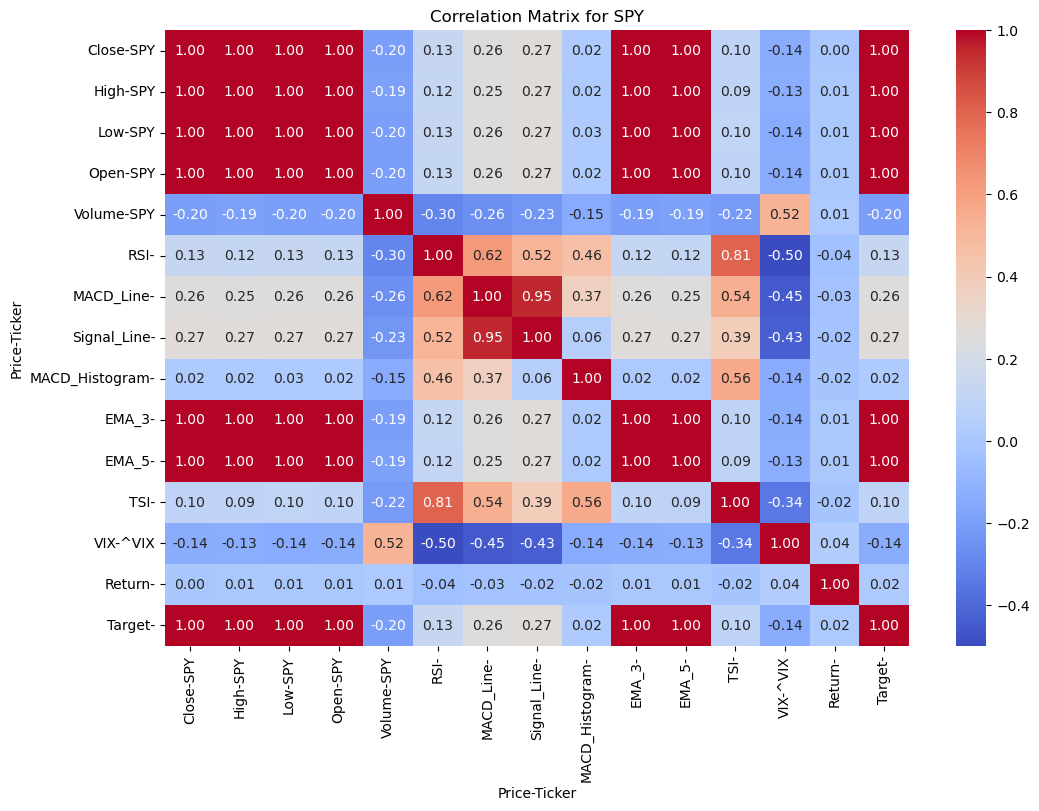

=== Correlation Analysis for QQQ ===


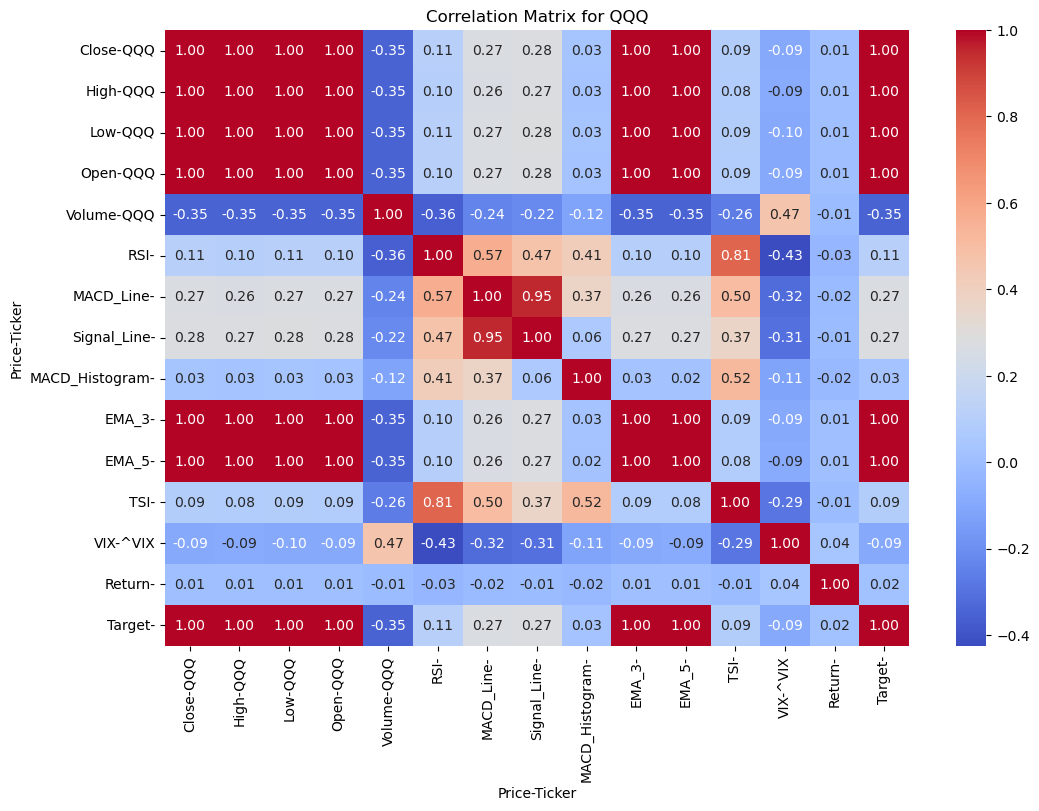

=== Correlation Analysis for DIA ===


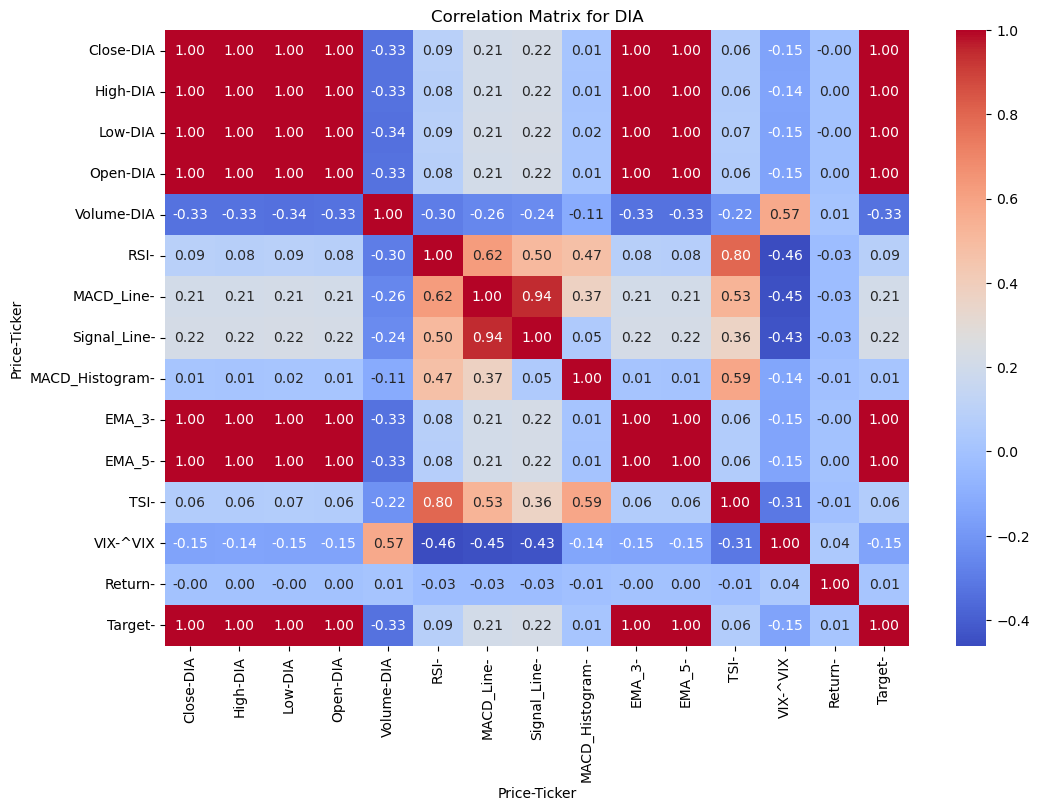

In [82]:
# Function to compute and plot correlation matrix
def plot_correlation_matrix(df, ticker):
    df = df.copy()
    
    # Drop rows with NaN values (especially from indicators and shift)
    df.dropna(inplace=True)
    
    # Add the target column (next day's closing price)
    df['Target'] = df['Close'].shift(-1)

    # Re-drop last row (now has NaN in Target)
    df.dropna(inplace=True)

    # Compute correlation matrix
    correlation = df.corr()

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f'Correlation Matrix for {ticker}')
    plt.show()

# Apply to all 3 tickers
for ticker in ['SPY', 'QQQ', 'DIA']:
    print(f"=== Correlation Analysis for {ticker} ===")
    plot_correlation_matrix(data[ticker], ticker)

# 5. Flatten MultiIndex Columns for Training

In [83]:
# ----------------------------
# A) FLATTEN MultiIndex columns
# ----------------------------
df_flat = data['SPY']  # or whatever ticker
df_flat.columns = df_flat.columns.get_level_values(0)
# Now df_flat.columns might look like:
#   ['Close','High','Low','Open','Volume','RSI','MACD_Line','Signal_Line','MACD_Histogram',
#    'EMA_3','EMA_5','TSI','VIX','Return']
#
# Replace data['SPY'] with this flattened version:
data['SPY'] = df_flat.copy()

# Repeat for QQQ and DIA:
for ticker in ['QQQ','DIA']:
    df_flat = data[ticker]
    df_flat.columns = df_flat.columns.get_level_values(0)
    data[ticker] = df_flat.copy()

# 6. Train XGBoost Model



=== TICKER: SPY ===
Total days: 6,356   |   Initial train size: 5,084
Trying params: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_lambda': 5, 'gamma': 1}
Validation MSE: 4451.536207
Trying params: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.03, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_lambda': 3, 'gamma': 0.5}
Validation MSE: 4448.418793
Trying params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 10, 'gamma': 2}
Validation MSE: 4387.371411
Best hyperparameters for SPY: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 10, 'gamma': 2}
Trained through 2020-05-05, forecasted 2020-05-06, AE=1.26, SE=1.59, APE=0.48%, R²_so_far=nan
Trained through 2020-09-25, forecasted 2020-09-28, AE=1.88, SE=3.55, APE=0.60%, R²_so_far=0.9535
Trained through 2021-02-19, forecasted 2021-

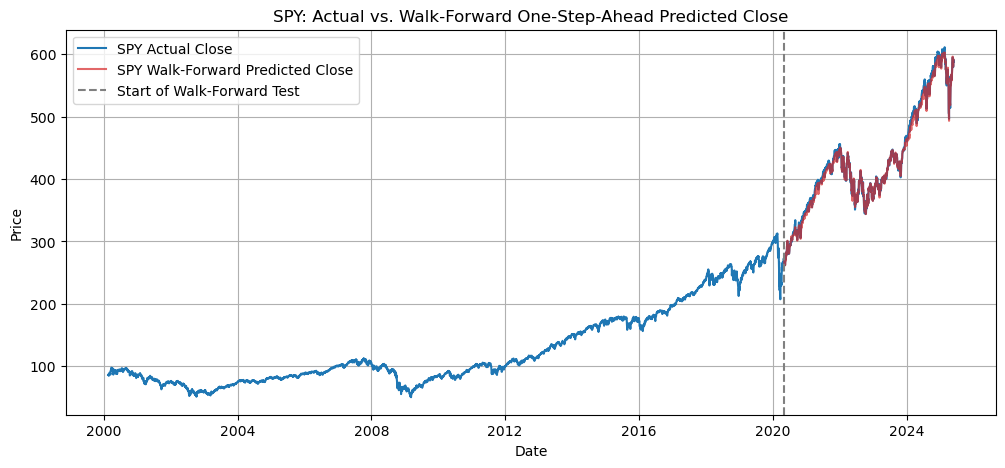

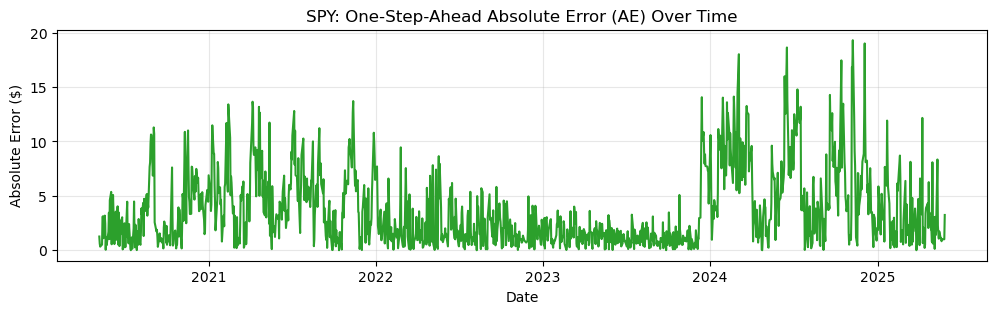

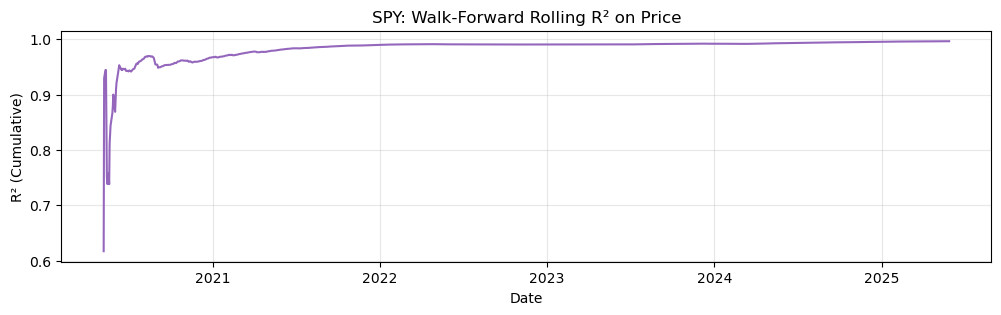



=== TICKER: QQQ ===
Total days: 6,356   |   Initial train size: 5,084
Trying params: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_lambda': 5, 'gamma': 1}
Validation MSE: 3278.677863
Trying params: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.03, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_lambda': 3, 'gamma': 0.5}
Validation MSE: 3289.289456
Trying params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 10, 'gamma': 2}
Validation MSE: 3254.414146
Best hyperparameters for QQQ: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 10, 'gamma': 2}
Trained through 2020-05-05, forecasted 2020-05-06, AE=0.29, SE=0.09, APE=0.14%, R²_so_far=nan
Trained through 2020-09-25, forecasted 2020-09-28, AE=2.96, SE=8.77, APE=1.10%, R²_so_far=0.8627
Trained through 2021-02-19, forecasted 2021-

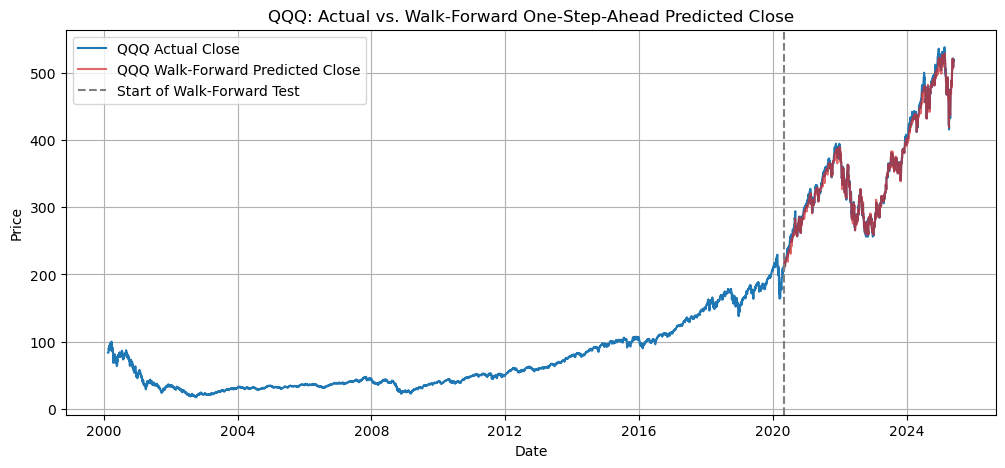

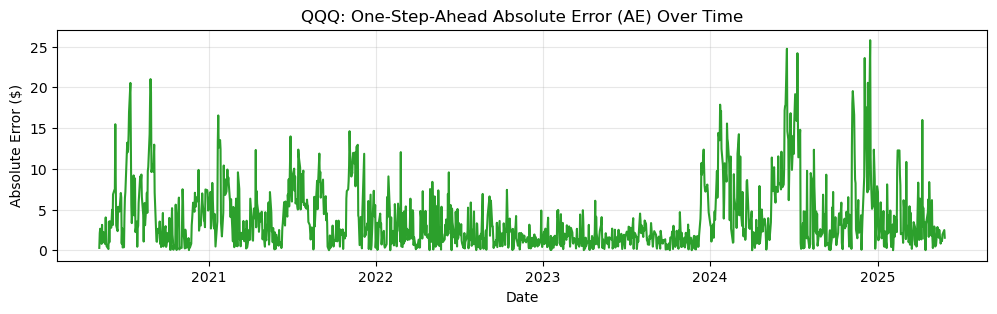

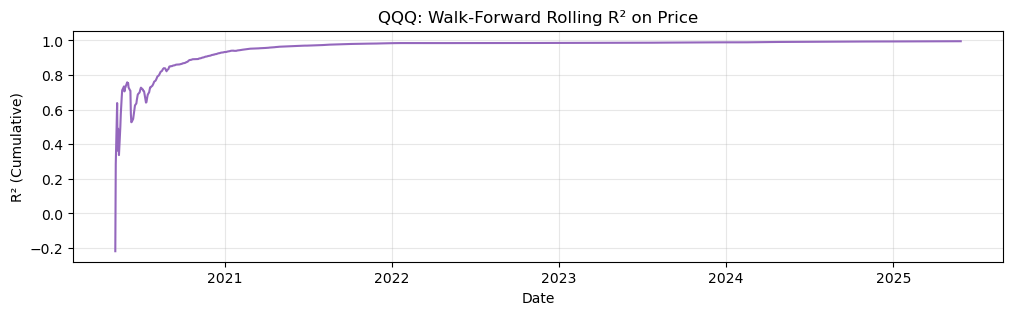



=== TICKER: DIA ===
Total days: 6,356   |   Initial train size: 5,084
Trying params: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_lambda': 5, 'gamma': 1}
Validation MSE: 4330.703699
Trying params: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.03, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_lambda': 3, 'gamma': 0.5}
Validation MSE: 4336.437717
Trying params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 10, 'gamma': 2}
Validation MSE: 4303.457150
Best hyperparameters for DIA: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 10, 'gamma': 2}
Trained through 2020-05-05, forecasted 2020-05-06, AE=1.42, SE=2.02, APE=0.66%, R²_so_far=nan
Trained through 2020-09-25, forecasted 2020-09-28, AE=1.28, SE=1.63, APE=0.50%, R²_so_far=0.9829
Trained through 2021-02-19, forecasted 2021-

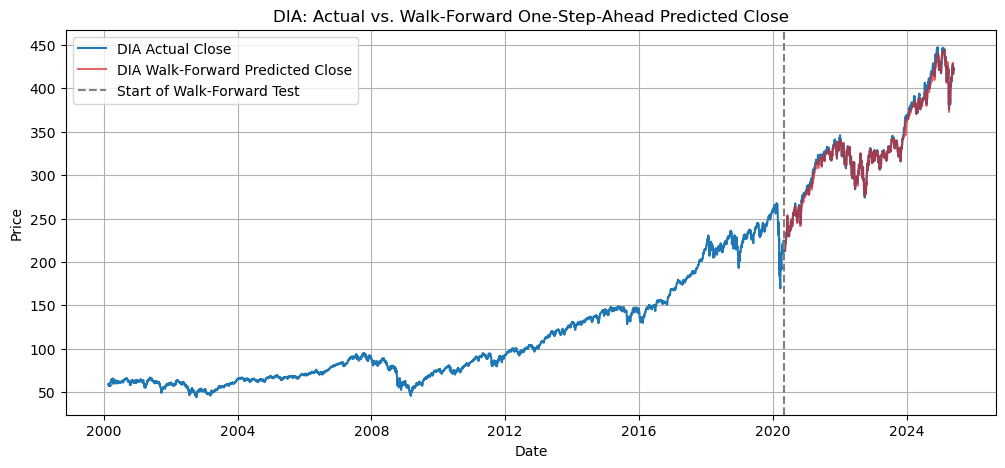

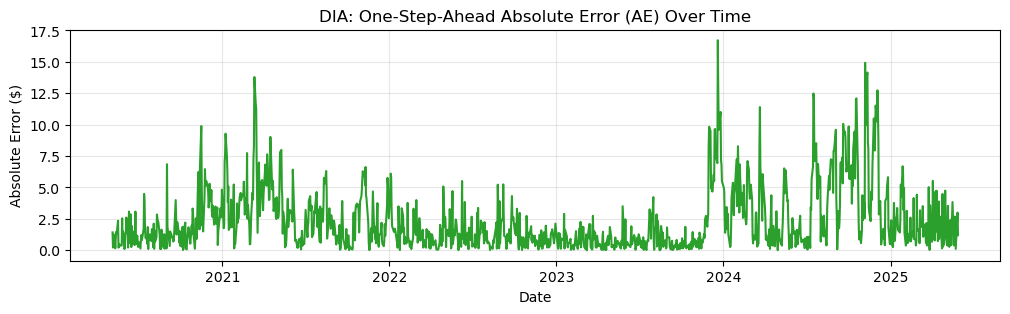

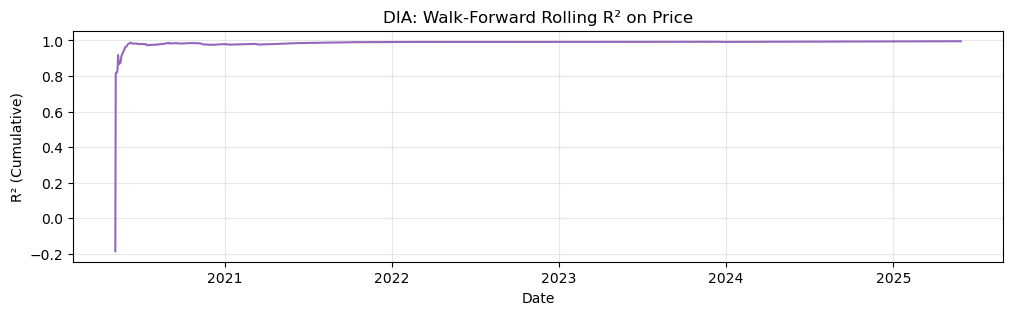

In [71]:
# Features to use
features = ['Close', 'Open', 'High', 'Low', 'Volume', 'EMA_3', 'EMA_5', 'RSI', 'MACD_Histogram', 'TSI', 'VIX']

# List of tickers to process
tickers = ['SPY', 'QQQ', 'DIA']

# Manual hyperparameter tuning configurations
param_grid = [
    {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_lambda': 5, 'gamma': 1},
    {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.03, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_lambda': 3, 'gamma': 0.5},
    {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 10, 'gamma': 2}
]

for ticker in tickers:
    print(f"\n\n=== TICKER: {ticker} ===")

    # ────────────────────────────────────────────────────────
    # (A) PREPARE THE DATAFRAME FOR NEXT‐DAY “CLOSE” FORECASTING
    # ────────────────────────────────────────────────────────

    # 1) Grab the flattened DataFrame for this ticker
    df = data[ticker].copy()   # assume already flattened

    # 2) Create the next‐day‐close target: TargetClose[t] = Close[t+1]
    df['TargetClose'] = df['Close'].shift(-1)

    # 3)_DROP rows where TargetClose is NaN (i.e. the final row)
    df = df.dropna(subset=['TargetClose']).copy()

    # 4) Extract arrays for walk‐forward
    X_all   = df[features].values        # shape = (N, n_features)
    y_all   = df['TargetClose'].values    # shape = (N,)
    dates   = df.index                    # DatetimeIndex length = N

    # 5) Compute initial‐train size (80% of rows)
    N = len(df)
    initial_train_size = int(0.8 * N)
    print(f"Total days: {N:,}   |   Initial train size: {initial_train_size:,}")

    # 6) Prepare placeholders for forecasts and actual closes
    pred_close_walk   = pd.Series(data=np.nan, index=dates)   # predicted Close[t] (forecast of t+1)
    actual_close_walk = df['Close'].copy()                    # actual Close[t]

    # We will store one‐step‐ahead errors (AE, SE, APE, R²) in lists
    ae_list   = []   # absolute error = |y_true - y_pred|
    se_list   = []   # squared error  = (y_true - y_pred)^2
    ape_list  = []   # absolute percentage error = |y_true - y_pred| / |y_true|
    r2_list   = []   # rolling R² (cumulative)
    date_list = []

    # ────────────────────────────────────────────────────────
    # (B) HYPERPARAMETER TUNING ON INITIAL TRAINING DATA
    # ────────────────────────────────────────────────────────

    # Use the initial training data for tuning
    train_idx = np.arange(initial_train_size)
    X_train = X_all[train_idx, :]
    y_train = y_all[train_idx]
    
    # Split training data into train and validation sets (80-20 split of training data)
    val_split = int(0.8 * initial_train_size)
    X_train_split = X_train[:val_split, :]
    y_train_split = y_train[:val_split]
    X_val = X_train[val_split:, :]
    y_val = y_train[val_split:]
    
    # Scale features for tuning
    scaler = MinMaxScaler()
    X_train_split_scaled = scaler.fit_transform(X_train_split)
    X_val_scaled = scaler.transform(X_val)
    
    best_val_mse = float('inf')
    best_params = None
    best_model = None
    
    for params in param_grid:
        print(f"Trying params: {params}")
        model = XGBRegressor(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            learning_rate=params['learning_rate'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            reg_lambda=params['reg_lambda'],
            gamma=params['gamma'],
            objective='reg:squarederror',
            random_state=42,
            verbosity=0
        )
        model.fit(X_train_split_scaled, y_train_split)
        y_val_pred = model.predict(X_val_scaled)
        val_mse = mean_squared_error(y_val, y_val_pred)
        print(f"Validation MSE: {val_mse:.6f}")
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_params = params
            best_model = model
    
    print(f"Best hyperparameters for {ticker}: {best_params}")
    
    # ────────────────────────────────────────────────────────
    # (C) WALK‐FORWARD LOOP (EXPANDING WINDOW) WITH BEST MODEL
    # ────────────────────────────────────────────────────────

    for day_idx in range(initial_train_size, N):
        # (C.1) Extract train‐block [0 … day_idx-1] and test‐point = day_idx
        train_idx = np.arange(day_idx)       # [0, 1, …, day_idx-1]
        test_idx  = day_idx                  # single integer

        X_train = X_all[train_idx, :]        # features rows 0…day_idx-1
        y_train = y_all[train_idx]           # targets rows 0…day_idx-1

        X_test  = X_all[test_idx:test_idx+1, :]
        # shape = (1, n_features): features of row “day_idx” (to predict Close at day_idx+1)

        # (C.2) Scale features (fit on train, transform test)
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        # (C.3) Train best XGBoost model
        model = XGBRegressor(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            learning_rate=best_params['learning_rate'],
            subsample=best_params['subsample'],
            colsample_bytree=best_params['colsample_bytree'],
            reg_lambda=best_params['reg_lambda'],
            gamma=best_params['gamma'],
            objective='reg:squarederror',
            random_state=42,
            verbosity=0
        )
        model.fit(X_train_scaled, y_train)

        # (C.4) One‐step‐ahead forecast: predict Close for next day
        y_pred_next_close = model.predict(X_test_scaled)[0]
        pred_close_walk.iloc[day_idx] = y_pred_next_close

        # (Cimaginary number) Record errors for this “held‐out day_idx” 
        actual_c = actual_close_walk.iloc[day_idx]
        ae_day   = abs(actual_c - y_pred_next_close)                   # absolute error
        se_day   = (actual_c - y_pred_next_close) ** 2                  # squared error
        ape_day  = ae_day / abs(actual_c) * 100 if actual_c != 0 else np.nan

        ae_list.append(ae_day)
        se_list.append(se_day)
        ape_list.append(ape_day)
        date_list.append(dates[day_idx])

        # (C.6) Compute rolling R² over all forecasts so far
        if len(ae_list) > 1:
            y_true_so_far = actual_close_walk.loc[date_list]
            y_pred_so_far = pred_close_walk.loc[date_list]
            r2_so_far     = r2_score(y_true_so_far, y_pred_so_far)
        else:
            r2_so_far = np.nan
        r2_list.append(r2_so_far)

        # Print progress every 100 walk-forward days
        if (day_idx - initial_train_size) % 100 == 0:
            print(
                f"Trained through {dates[day_idx-1].date()}, "
                f"forecasted {dates[day_idx].date()}, "
                f"AE={ae_day:.2f}, SE={se_day:.2f}, APE={ape_day:.2f}%, "
                f"R²_so_far={r2_so_far:.4f}"
            )

    # ────────────────────────────────────────────────────────
    # (D) AGGREGATE & PRINT SUMMARY STATISTICS FOR THIS TICKER
    # ────────────────────────────────────────────────────────

    # Build a small DataFrame of the walk‐forward errors
    errors_df = pd.DataFrame({
        'Date'    : date_list,
        'AE'      : ae_list,
        'SE'      : se_list,
        'APE'     : ape_list,
        'R2_so_far': r2_list
    }).set_index('Date')

    # Compute overall metrics:
    mean_mae   = np.mean(errors_df['AE'])
    mean_mse   = np.mean(errors_df['SE'])
    mean_rmse  = np.sqrt(mean_mse)
    mean_mape  = np.mean(errors_df['APE'])
    final_r2   = errors_df['R2_so_far'].iloc[-1]  # last cumulative R²

    print(f"\n>>> {ticker} WALK‐FORWARD SUMMARY <<<")
    print(f"One‐step‐ahead MAE:    {mean_mae:.4f}")
    print(f"One‐step‐ahead MSE:    {mean_mse:.4f}")
    print(f"One‐step‐ahead RMSE:   {mean_rmse:.4f}")
    print(f"One‐step‐ahead MAPE:   {mean_mape:.2f}%")
    print(f"One‐step‐ahead R²:     {final_r2:.4f}\n")

    # 1) Plot actual vs. predicted close (walk‐forward)
    plt.figure(figsize=(12,5))
    plt.plot(
        actual_close_walk.index,
        actual_close_walk.values,
        label=f"{ticker} Actual Close",
        color='tab:blue'
    )
    plt.plot(
        pred_close_walk.index,
        pred_close_walk.values,
        label=f"{ticker} Walk‐Forward Predicted Close",
        color='tab:red',
        alpha=0.7
    )
    plt.axvline(
        x=dates[initial_train_size],
        color='gray',
        linestyle='--',
        label="Start of Walk‐Forward Test"
    )
    plt.title(f"{ticker}: Actual vs. Walk‐Forward One‐Step‐Ahead Predicted Close")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2) Plot day‐by‐day AE (MAE) over time
    plt.figure(figsize=(12,3))
    plt.plot(errors_df.index, errors_df['AE'], color='tab:green')
    plt.title(f"{ticker}: One‐Step‐Ahead Absolute Error (AE) Over Time")
    plt.xlabel("Date")
    plt.ylabel("Absolute Error ($)")
    plt.grid(alpha=0.3)
    plt.show()

    # 3) Plot rolling R² over time
    plt.figure(figsize=(12,3))
    plt.plot(errors_df.index, errors_df['R2_so_far'], color='tab:purple')
    plt.title(f"{ticker}: Walk‐Forward Rolling R² on Price")
    plt.xlabel("Date")
    plt.ylabel("R² (Cumulative)")
    plt.grid(alpha=0.3)
    plt.show()

# 7. Train LSTM Model

In [84]:
# 7. LSTM Model (Walk-Forward Dynamic Retraining & Manual Hyperparameter Tuning)

# Features to use
features = ['Close', 'Open', 'High', 'Low', 'Volume', 'EMA_3', 'EMA_5', 'RSI', 'MACD_Histogram', 'TSI', 'VIX']

# LSTM settings
timesteps = 30
train_frac = 0.8
epochs = 10

# Build LSTM model
def build_lstm_model(units_1, units_2, dropout, learning_rate):
    model = Sequential([
        LSTM(units_1, input_shape=(timesteps, len(features)), return_sequences=True),
        Dropout(dropout),
        LSTM(units_2),
        Dropout(dropout),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate), loss='mse')
    return model

# Manual hyperparameter tuning configurations
param_grid = [
    {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32},
    {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32},
    {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
]

for ticker in ['SPY', 'QQQ', 'DIA']:
    print(f"\n\n=== TICKER: {ticker} ===")

    # Check for missing values
    if data[ticker][features].isna().any().any():
        print(f"Warning: Missing values in {ticker}: {data[ticker][features].isna().sum()}")
        data[ticker][features] = data[ticker][features].fillna(method='ffill')

    # Prepare DataFrame
    df = data[ticker].copy()
    df['TargetClose'] = df['Close'].shift(-1)
    df.dropna(subset=['TargetClose'], inplace=True)
    
    X = df[features].values
    y = df['TargetClose'].values
    dates = df.index
    N = len(df)
    split = int(train_frac * N)
    print(f"Total days: {N:,} | Initial train size: {split:,}")

    # Scale data
    feat_scaler = MinMaxScaler().fit(X[:split])
    targ_scaler = MinMaxScaler().fit(y[:split].reshape(-1,1))
    Xs = feat_scaler.transform(X)
    ys = targ_scaler.transform(y.reshape(-1,1)).ravel()
    
    # Build training sequences
    X_train_seq, y_train_seq = [], []
    for i in range(timesteps, split):
        X_train_seq.append(Xs[i-timesteps:i])
        y_train_seq.append(ys[i])
    X_train_seq = np.array(X_train_seq)
    y_train_seq = np.array(y_train_seq)
    
    # Manual hyperparameter tuning
    best_val_loss = float('inf')
    best_params = None
    best_model = None
    val_split = int(0.8 * len(X_train_seq))  # Use last 20% of training for validation
    
    for params in param_grid:
        print(f"Trying params: {params}")
        model = build_lstm_model(
            params['units_1'], params['units_2'], params['dropout'], params['learning_rate']
        )
        model.fit(
            X_train_seq[:val_split], y_train_seq[:val_split],
            epochs=5, batch_size=params['batch_size'], verbose=0,
            validation_data=(X_train_seq[val_split:], y_train_seq[val_split:])
        )
        val_loss = model.evaluate(X_train_seq[val_split:], y_train_seq[val_split:], verbose=0)
        print(f"Validation loss: {val_loss:.6f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = params
            best_model = model
    
    print(f"Best hyperparameters for {ticker}: {best_params}")
    
    # Train best model on full training data
    best_model.fit(X_train_seq, y_train_seq, epochs=epochs, batch_size=best_params['batch_size'], verbose=1)
    
    # Define grid of retraining frequencies and window sizes
    retrain_configs = [
        (20, 30), (20, 60), (20, 90),
        (30, 30), (30, 60), (30, 90),
        (60, 30), (60, 60), (60, 90)
    ]

    best_r2 = float('-inf')
    best_retrain_config = None
    best_forecast = {}

    for retrain_freq, retrain_window in retrain_configs:
        print(f"\n Testing retrain_freq={retrain_freq}, retrain_window={retrain_window}")
    
        window = deque(Xs[split - timesteps:split], maxlen=timesteps)
        preds, trues, pred_dates, ape_list, se_list = [], [], [], [], []

        for i in range(split, N):
            x_in = np.array(window).reshape(1, timesteps, X.shape[1])
            y_pred_s = best_model.predict(x_in, verbose=0)[0, 0]
            y_pred = targ_scaler.inverse_transform([[y_pred_s]])[0, 0]

            actual_c = df['Close'].iloc[i]
            preds.append(y_pred)
            trues.append(actual_c)
            pred_dates.append(dates[i])

            ae = abs(actual_c - y_pred)
            se = (actual_c - y_pred) ** 2
            ape = ae / abs(actual_c) * 100 if actual_c != 0 else 0
            ape_list.append(ape)
            se_list.append(se)

            window.append(Xs[i])

            if (i - split) % retrain_freq == 0 and i >= retrain_window:
                start_idx = i - retrain_window + timesteps
                end_idx = i
                if start_idx < end_idx:
                    X_finetune_seq, y_finetune_seq = [], []
                    for j in range(start_idx, end_idx):
                        if j - timesteps >= 0:  # safeguard
                            X_finetune_seq.append(Xs[j - timesteps:j])
                            y_finetune_seq.append(ys[j])
                    if len(X_finetune_seq) > 0:
                        X_finetune_seq = np.array(X_finetune_seq)
                        y_finetune_seq = np.array(y_finetune_seq)
                        best_model.fit(X_finetune_seq, y_finetune_seq, epochs=3, batch_size=best_params['batch_size'], verbose=0)

        # Evaluate performance
        r2 = r2_score(trues, preds)
        print(f"  → R²={r2:.4f}")

        if r2 > best_r2:
            best_r2 = r2
            best_retrain_config = (retrain_freq, retrain_window)
            best_forecast = {
                'preds': preds,
                'trues': trues,
                'dates': pred_dates,
                'ae': [abs(t - p) for t, p in zip(trues, preds)],
                'se': se_list,
                'ape': ape_list
            }

    # Print best config and reuse for plotting
    print(f"\n Best retrain config: freq={best_retrain_config[0]}, window={best_retrain_config[1]} | R²={best_r2:.4f}")

    # Compute metrics using best forecast
    mae = mean_absolute_error(best_forecast['trues'], best_forecast['preds'])
    mse = mean_squared_error(best_forecast['trues'], best_forecast['preds'])
    rmse = np.sqrt(mse)
    mape = np.nanmean(best_forecast['ape'])
    r2 = r2_score(best_forecast['trues'], best_forecast['preds'])
    pearson_corr, _ = pearsonr(best_forecast['trues'], best_forecast['preds'])

    print(f"\n>>> {ticker} WALK-FORWARD TEST SUMMARY <<<")
    print(f"One-step-ahead MAE:    {mae:.2f}")
    print(f"One-step-ahead MSE:    {mse:.2f}")
    print(f"One-step-ahead RMSE:   {rmse:.2f}")
    print(f"One-step-ahead MAPE:   {mape:.2f}%")
    print(f"One-step-ahead R²:     {r2:.4f}")
    print(f"One-step-ahead Pearson: {pearson_corr:.2f}\n")

    # Create error DataFrame
    errors_df = pd.DataFrame({
        'Date': best_forecast['dates'],
        'AE': best_forecast['ae'],
        'SE': best_forecast['se'],
        'APE': best_forecast['ape'],
        'R2_so_far': [r2_score(best_forecast['trues'][:i+1], best_forecast['preds'][:i+1]) if i > 1 else np.nan for i in range(len(best_forecast['preds']))]
    }).set_index('Date')

    # Plot actual vs predicted
    plt.figure(figsize=(12, 5))
    plt.plot(df.index, df['Close'], label=f"{ticker} Actual Close", color='tab:blue')
    plt.plot(best_forecast['dates'], best_forecast['preds'], label=f"{ticker} Walk-Forward Predicted Close", color='tab:red', alpha=0.7)
    plt.axvline(dates[split], color='gray', linestyle='--', label='Start of Walk-Forward Test')
    plt.title(f"{ticker}: Actual vs. Walk-Forward One-Step-Ahead Predicted Close")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot AE
    plt.figure(figsize=(12, 3))
    plt.plot(errors_df.index, errors_df['AE'], color='tab:green')
    plt.title(f"{ticker}: One-Step-Ahead Absolute Error (AE)")
    plt.xlabel("Date")
    plt.ylabel("Absolute Error ($)")
    plt.grid(True, alpha=0.5)
    plt.show()

    # Plot rolling R²
    plt.figure(figsize=(12, 3))
    plt.plot(errors_df.index, errors_df['R2_so_far'], color='tab:purple')
    plt.title(f"{ticker}: Walk-Forward Rolling R²")
    plt.xlabel("Date")
    plt.ylabel("R² (Cumulative)")
    plt.grid(True, alpha=0.5)
    plt.show()



=== TICKER: SPY ===
Total days: 6,356 | Initial train size: 5,084
Trying params: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
Validation loss: 0.016598
Trying params: {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}
Validation loss: 0.017271
Trying params: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
Validation loss: 0.027364
Best hyperparameters for SPY: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0014
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.3050e-04
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 7.9144e-04
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 7.9953e-04
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 6.9127e-04
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 6.001

KeyboardInterrupt: 

# 8. Train GRU Model



=== TICKER: SPY ===


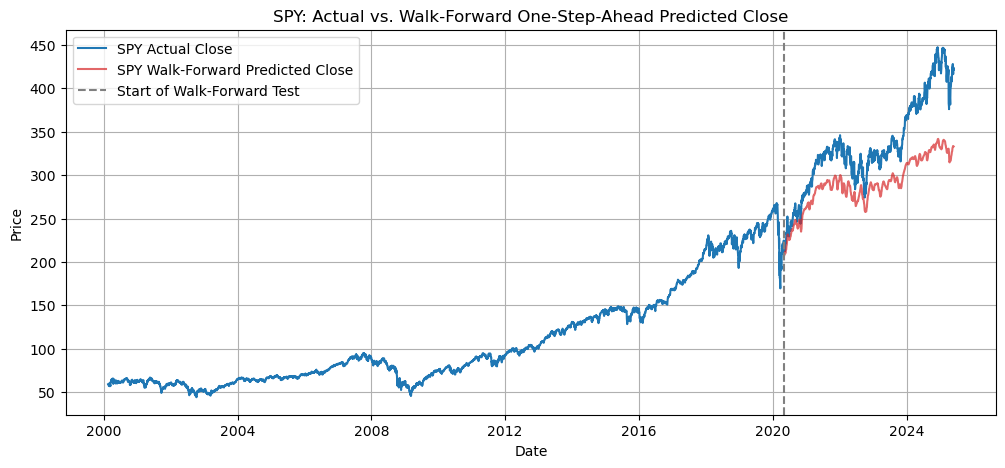

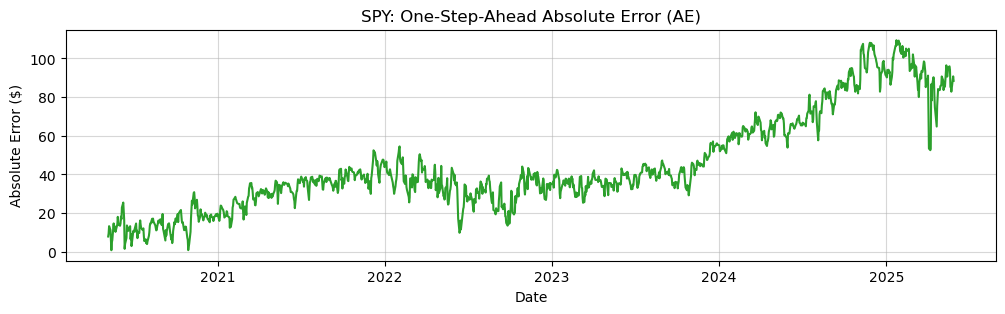

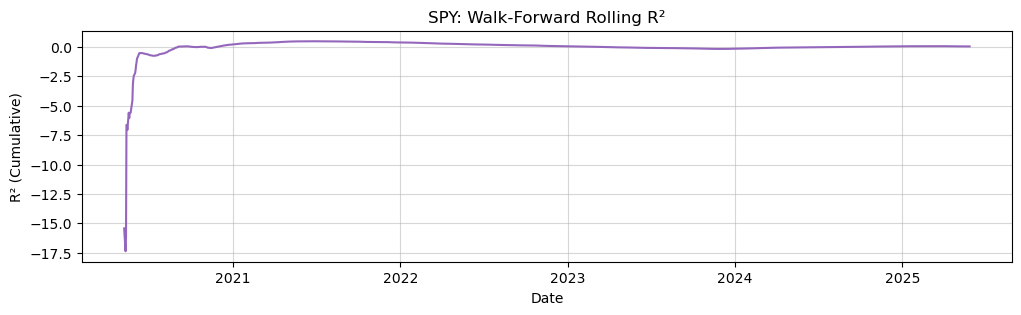



=== TICKER: QQQ ===


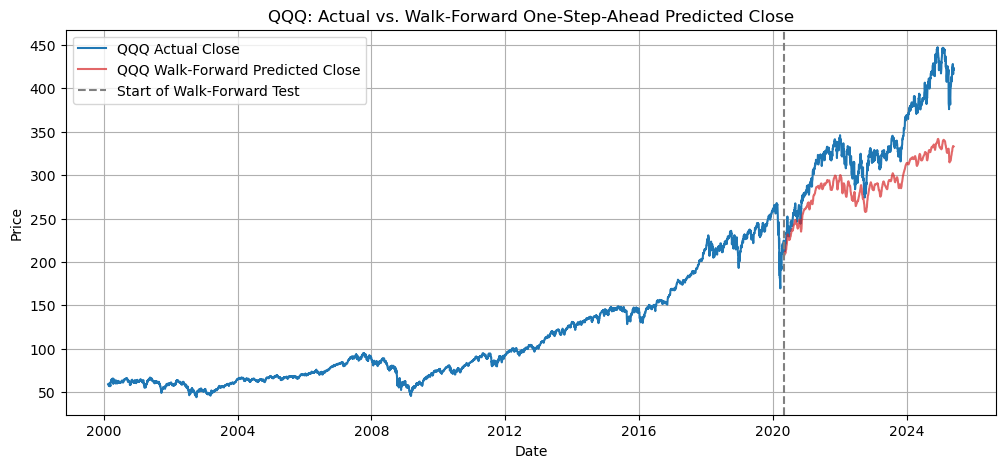

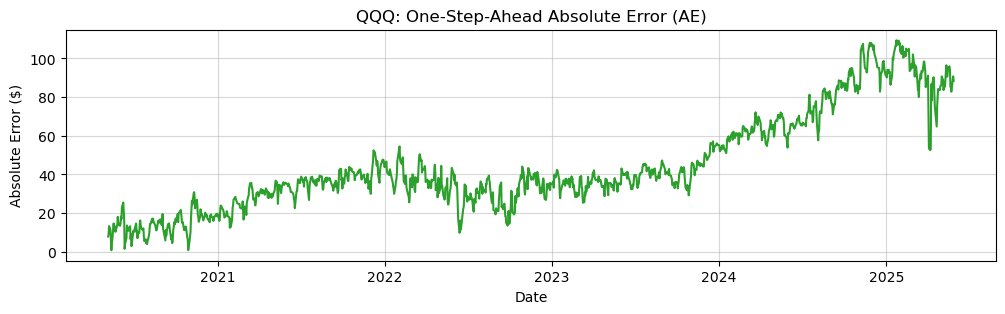

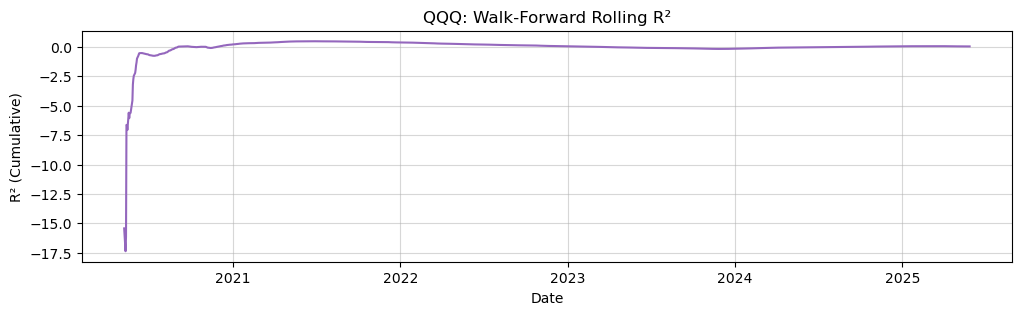



=== TICKER: DIA ===


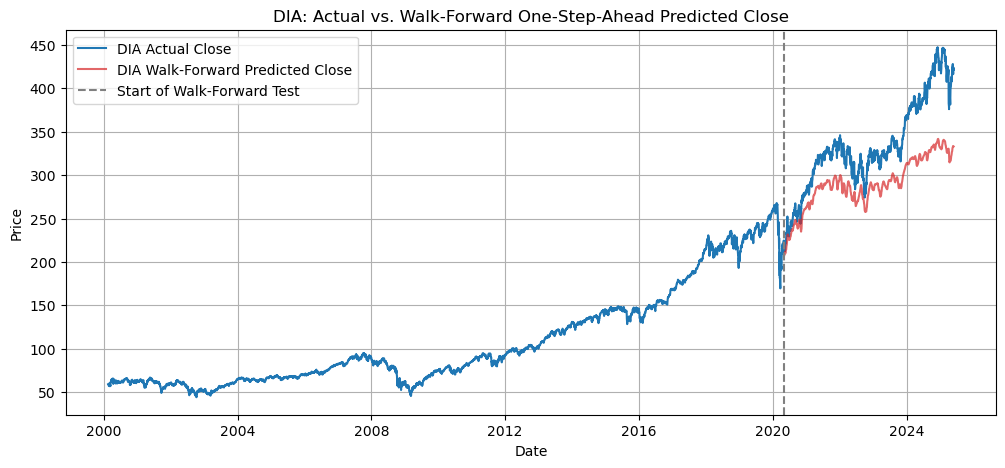

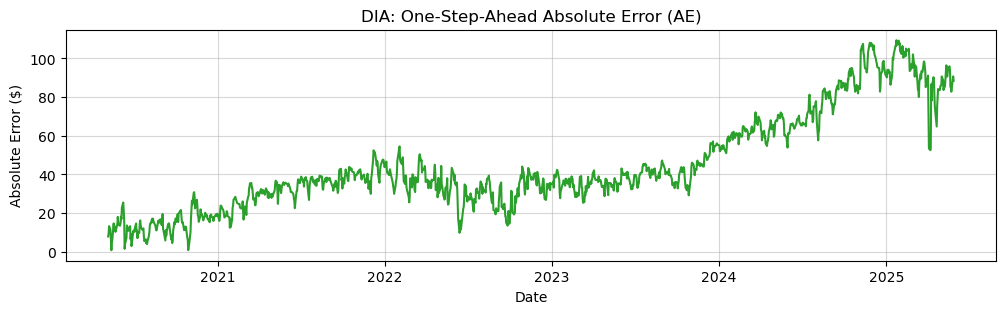

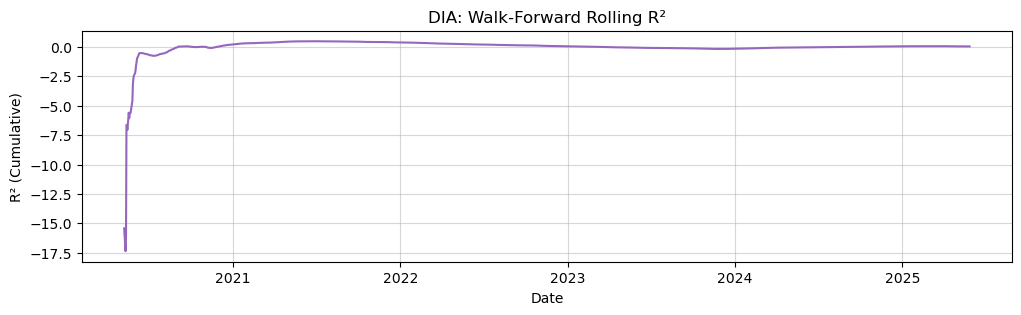

In [24]:
# 8. GRU Model (Walk-Forward Dynamic Retraining & Manual Hyperparameter Tuning)

# Features to use
features = ['Close', 'Open', 'High', 'Low', 'Volume',
            'EMA_3', 'EMA_5', 'RSI', 'MACD_Histogram', 'TSI', 'VIX']

# GRU settings
timesteps   = 30
train_frac  = 0.8
epochs      = 10

# Build GRU model
def build_gru_model(units_1, units_2, dropout, learning_rate):
    model = Sequential([
        GRU(units_1, input_shape=(timesteps, len(features)), return_sequences=True),
        Dropout(dropout),
        GRU(units_2),
        Dropout(dropout),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate), loss='mse')
    return model

# Manual hyperparameter tuning configurations
param_grid = [
    {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32},
    {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32},
    {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
]

# Grid of (retrain_freq, retrain_window) to test
retrain_configs = [
    (20, 30), (20, 60), (20, 90),
    (30, 30), (30, 60), (30, 90),
    (60, 30), (60, 60), (60, 90)
]

for ticker in ['SPY','QQQ','DIA']:
    print(f"\n\n=== TICKER: {ticker} ===")
    # 1) Missing values check
    if data[ticker][features].isna().any().any():
        data[ticker][features].fillna(method='ffill', inplace=True)

    # 2) Prepare data
    df = data[ticker].copy()
    df['TargetClose'] = df['Close'].shift(-1)
    df.dropna(subset=['TargetClose'], inplace=True)

    X = df[features].values
    y = df['TargetClose'].values
    dates = df.index
    N = len(df)
    split = int(train_frac * N)
    print(f"Total days: {N}, train up to index {split}")

    # 3) Scale & sequence build
    feat_scaler = MinMaxScaler().fit(X[:split])
    targ_scaler = MinMaxScaler().fit(y[:split].reshape(-1,1))
    Xs = feat_scaler.transform(X)
    ys = targ_scaler.transform(y.reshape(-1,1)).ravel()

    X_train_seq, y_train_seq = [], []
    for i in range(timesteps, split):
        X_train_seq.append(Xs[i-timesteps:i])
        y_train_seq.append(ys[i])
    X_train_seq = np.array(X_train_seq)
    y_train_seq = np.array(y_train_seq)

    # 4) Hyperparameter tuning
    best_val_loss = float('inf')
    best_params   = None
    best_model    = None
    val_split     = int(0.8 * len(X_train_seq))

    for params in param_grid:
        print(f" Tuning: {params}")
        model = build_gru_model(params['units_1'], params['units_2'],
                                params['dropout'], params['learning_rate'])
        model.fit(X_train_seq[:val_split], y_train_seq[:val_split],
                  epochs=5, batch_size=params['batch_size'], verbose=0,
                  validation_data=(X_train_seq[val_split:], y_train_seq[val_split:]))
        val_loss = model.evaluate(X_train_seq[val_split:], y_train_seq[val_split:], verbose=0)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params   = params
            best_model    = model

    print(f" Best GRU params: {best_params}")

    # 5) Train on full training block
    best_model.fit(X_train_seq, y_train_seq,
                   epochs=epochs, batch_size=best_params['batch_size'], verbose=1)

    # 6) Walk-forward with grid search over retrain configs
    best_r2             = float('-inf')
    best_retrain_config = None
    best_forecast       = {}

    for retrain_freq, retrain_window in retrain_configs:
        print(f"\n Testing retrain_freq={retrain_freq}, retrain_window={retrain_window}")
        window = deque(Xs[split-timesteps:split], maxlen=timesteps)
        preds, trues, pred_dates, ape_list, se_list = [], [], [], [], []

        for i in range(split, N):
            # predict
            x_in = np.array(window).reshape(1, timesteps, X.shape[1])
            y_pred_s = best_model.predict(x_in, verbose=0)[0,0]
            y_pred   = targ_scaler.inverse_transform([[y_pred_s]])[0,0]

            actual_c = df['Close'].iloc[i]
            preds.append(y_pred); trues.append(actual_c); pred_dates.append(dates[i])
            ae = abs(actual_c-y_pred); se = ae**2
            ape_list.append(ae/abs(actual_c)*100 if actual_c else 0)
            se_list.append(se)
            window.append(Xs[i])

            # periodic fine-tune
            if (i-split) % retrain_freq == 0 and i >= retrain_window:
                start_idx = i - retrain_window + timesteps
                if start_idx < i:
                    X_ft, y_ft = [], []
                    for j in range(start_idx, i):
                        X_ft.append(Xs[j-timesteps:j])
                        y_ft.append(ys[j])
                    if X_ft:
                        X_ft = np.array(X_ft)
                        y_ft = np.array(y_ft)
                        best_model.fit(X_ft, y_ft,
                                       epochs=3,
                                       batch_size=best_params['batch_size'],
                                       verbose=0)

        # evaluate this config
        r2 = r2_score(trues, preds)
        print(f"  → R²={r2:.4f}")
        if r2 > best_r2:
            best_r2             = r2
            best_retrain_config = (retrain_freq, retrain_window)
            best_forecast       = {
                'preds': preds,
                'trues': trues,
                'dates': pred_dates,
                'ae':    [abs(t-p) for t,p in zip(trues,preds)],
                'se':    se_list,
                'ape':   ape_list
            }

    print(f"\n Best retrain config: freq={best_retrain_config[0]}, window={best_retrain_config[1]} | R²={best_r2:.4f}")

    # 7) Metrics & plots using best_forecast
    mae = mean_absolute_error(best_forecast['trues'], best_forecast['preds'])
    mse = mean_squared_error(best_forecast['trues'], best_forecast['preds'])
    rmse = np.sqrt(mse)
    mape = np.nanmean(best_forecast['ape'])
    r2   = r2_score(best_forecast['trues'], best_forecast['preds'])
    pcorr,_ = pearsonr(best_forecast['trues'], best_forecast['preds'])

    print(f"\n>>> {ticker} WALK-FORWARD TEST SUMMARY <<<")
    print(f"One-step-ahead MAE:    {mae:.2f}")
    print(f"One-step-ahead MSE:    {mse:.2f}")
    print(f"One-step-ahead RMSE:   {rmse:.2f}")
    print(f"One-step-ahead MAPE:   {mape:.2f}%")
    print(f"One-step-ahead R²:     {r2:.4f}")
    print(f"One-step-ahead Pearson: {pcorr:.2f}\n")

    # Create error DataFrame
    errors_df = pd.DataFrame({
        'Date': best_forecast['dates'],
        'AE': best_forecast['ae'],
        'SE': best_forecast['se'],
        'APE': best_forecast['ape'],
        'R2_so_far': [r2_score(best_forecast['trues'][:i+1], best_forecast['preds'][:i+1]) if i > 1 else np.nan for i in range(len(best_forecast['preds']))]
    }).set_index('Date')

    # Plot actual vs predicted
    plt.figure(figsize=(12, 5))
    plt.plot(df.index, df['Close'], label=f"{ticker} Actual Close", color='tab:blue')
    plt.plot(best_forecast['dates'], best_forecast['preds'], label=f"{ticker} Walk-Forward Predicted Close", color='tab:red', alpha=0.7)
    plt.axvline(dates[split], color='gray', linestyle='--', label='Start of Walk-Forward Test')
    plt.title(f"{ticker}: Actual vs. Walk-Forward One-Step-Ahead Predicted Close")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot AE
    plt.figure(figsize=(12, 3))
    plt.plot(errors_df.index, errors_df['AE'], color='tab:green')
    plt.title(f"{ticker}: One-Step-Ahead Absolute Error (AE)")
    plt.xlabel("Date")
    plt.ylabel("Absolute Error ($)")
    plt.grid(True, alpha=0.5)
    plt.show()

    # Plot rolling R²
    plt.figure(figsize=(12, 3))
    plt.plot(errors_df.index, errors_df['R2_so_far'], color='tab:purple')
    plt.title(f"{ticker}: Walk-Forward Rolling R²")
    plt.xlabel("Date")
    plt.ylabel("R² (Cumulative)")
    plt.grid(True, alpha=0.5)
    plt.show()